## Plot OTM results for carbon for an ensemble of runs and multiple time periods
##### This version plots 2 time periods
##### This script creates the version of the plots for the OTM application paper
##### This version is for ensembles including variable weighting for non-outcropping water masses

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
from scipy.stats import sem

In [2]:
# Define run parameters

#basedir_ensemble = '../Outputs/12112024/' # Nitrate
#basedir_ensemble = '../Outputs/10112024/' # AOU


#basedir_ensemble = '../Outputs/09122024/' # Nitrate
#basedir_ensemble = '../Outputs/09122024/' # AOU

basedir_ensemble = '../Outputs/17012025/'

Cdef = 'aou'
avg_periods = np.array([[1990,2000,6],[2000,2010,6]])

init_early_p1 = avg_periods[0,0]
init_late_p1 = avg_periods[0,1]
len_p1 = avg_periods[0,2]
init_early_p2 = avg_periods[1,0]
init_late_p2 = avg_periods[1,1]
len_p2 = avg_periods[1,2]

#mid_early_p1 = str(init_early_p1 + len_p1/2-0.5)[0:4]
#mid_late_p1 = str(init_late_p1 +len_p1/2-0.5)[0:4]
#mid_early_p2 = str(init_early_p2 + len_p2/2-0.5)[0:4]
#mid_late_p2 = str(init_late_p2 +len_p2/2-0.5)[0:4]
mid_early_p1 = str(init_early_p1 + len_p1/2)[0:4]
mid_late_p1 = str(init_late_p1 +len_p1/2-0.5)[0:4]
mid_early_p2 = str(init_early_p2 + len_p2/2)[0:4]
mid_late_p2 = str(init_late_p2 +len_p2/2-0.5)[0:4]


print(mid_early_p1)
print(mid_late_p1)
print(mid_early_p2)
print(mid_late_p2)



Basins = xr.open_mfdataset('/home/users/nmackay/MTM/BSP_obs/Ehmen_NN/ERA5/nitrate_Cstar_components/BSP_ERA5_NN_*.nc').Basin

1993
2002
2003
2012


In [3]:
# Load previously saved ensemble mean data

ensemble_budget = xr.open_dataset(basedir_ensemble + 'ensemble_budget_' + Cdef + '.nc')

dC_OTM_all = ensemble_budget.OTM_flux
dC_OTM_dens_all = ensemble_budget.OTM_flux_dens
net_carbon_trans_all = ensemble_budget.net_carbon_trans
Cint_change_all = ensemble_budget.Cint_change
prior_flux_all = ensemble_budget.prior_flux
prior_flux_dens_all = ensemble_budget.prior_flux_dens
res_all = ensemble_budget.residual

prior_flux_all = xr.where(prior_flux_all==0,np.nan,prior_flux_all)


In [4]:
# Ensemble means of OTM runs from individual carbon predictions

for ap in np.arange(avg_periods.shape[0]):

    exec('dC_OTM_ensmean_p' + str(ap+1) + ' = np.nanmean(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('dC_prior_ensmean_p' + str(ap+1) + ' = np.nanmean(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('net_Ctrans_ensmean_p' + str(ap+1) + ' = np.nanmean(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('dC_inv_ensmean_p' + str(ap+1) + ' = np.nanmean(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('dC_res_ensmean_p' + str(ap+1) + ' = np.nanmean(res_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('dC_OTM_dens_ensmean_p' + str(ap+1) + ' = np.nanmean(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    exec('dC_prior_dens_ensmean_p' + str(ap+1) + ' = np.nanmean(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))')
    
    


In [5]:
# Calculate trends

OTM_p1p2_trend = (dC_OTM_ensmean_p2 - dC_OTM_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade
Ctrans_p1p2_trend = (net_Ctrans_ensmean_p2 - net_Ctrans_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade
inv_p1p2_trend = (dC_inv_ensmean_p2 - dC_inv_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade
prior_p1p2_trend = (dC_prior_ensmean_p2 - dC_prior_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade
OTM_dens_p1p2_trend = (dC_OTM_dens_ensmean_p2 - dC_OTM_dens_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade
prior_dens_p1p2_trend = (dC_prior_dens_ensmean_p2 - dC_prior_dens_ensmean_p1)/(init_early_p2 - init_early_p1)*10 # PgC/yr/decade


In [6]:
# Calculate error bounds from ensembles

for ap in np.arange(avg_periods.shape[0]):

    # Flux

    dC_OTM_lb = np.nanmean(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_ub = np.nanmax(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_err = np.stack((dC_OTM_lb,dC_OTM_ub),axis=1)
    dC_OTM_stdev = np.nanstd(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    prior_flux_lb = np.nanmean(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    prior_flux_ub = np.nanmax(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    prior_flux_err = np.stack((prior_flux_lb,prior_flux_ub),axis=1)
    prior_flux_stdev = np.nanstd(prior_flux_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    err = np.vstack((prior_flux_err,dC_OTM_err))
    stdev = np.vstack((prior_flux_stdev,dC_OTM_stdev))

    #exec('flux_err_p' + str(ap+1) + '=np.moveaxis(err,[0,1,2],[2,0,1])') # Use full ensemble envelope
    exec('flux_err_p' + str(ap+1) + '=stdev') # Use symmetric standard deviation of ensemble

    # Flux density

    dC_OTM_dens_lb = np.nanmean(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_dens_ub = np.nanmax(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_dens_err = np.stack((dC_OTM_dens_lb,dC_OTM_dens_ub),axis=1)
    dC_OTM_dens_stdev = np.nanstd(dC_OTM_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    prior_flux_dens_lb = np.nanmean(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    prior_flux_dens_ub = np.nanmax(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    prior_flux_dens_err = np.stack((prior_flux_dens_lb,prior_flux_dens_ub),axis=1)
    prior_flux_dens_stdev = np.nanstd(prior_flux_dens_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    err = np.vstack((prior_flux_dens_err,dC_OTM_dens_err))
    stdev = np.vstack((prior_flux_dens_stdev,dC_OTM_dens_stdev))

    exec('flux_dens_err_p' + str(ap+1) + '=stdev') # Use symmetric standard deviation of ensemble


# Calculate flux trend errors

flux_trend_p1p2_err = flux_err_p1 + flux_err_p2
flux_dens_trend_p1p2_err = flux_dens_err_p1 + flux_dens_err_p2


In [7]:
# Combining uncertainties from all different forcing datasets in budget terms, compared with ensemble mean as baseline

for ap in np.arange(avg_periods.shape[0]):

    # Flux

    dC_OTM_lb = np.nanmean(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_ub = np.nanmax(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    dC_OTM_err = np.vstack((dC_OTM_lb,dC_OTM_ub)).transpose()
    dC_OTM_stdev = np.nanstd(dC_OTM_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    # Transport

    net_Ctrans_lb = np.nanmean(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    net_Ctrans_ub = np.nanmax(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    net_Ctrans_err = np.stack((net_Ctrans_lb,net_Ctrans_ub),axis=1)
    net_Ctrans_stdev = np.nanstd(net_carbon_trans_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    # Interior change

    Cint_change_lb = np.nanmean(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmin(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    Cint_change_ub = np.nanmax(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4)) - np.nanmean(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4))
    Cint_change_err = np.stack((Cint_change_lb,Cint_change_ub),axis=1)
    Cint_change_stdev = np.nanstd(Cint_change_all[:,ap,:,:,:,:],axis=(1,2,3,4))

    # Budget

    budget_err = np.stack((net_Ctrans_err,dC_OTM_err,Cint_change_err,np.zeros((10,2))),axis=2) # Array axes: 0 = basin, 1 = bounds, 2 = budget variable
    budget_stdev = np.stack((net_Ctrans_stdev,dC_OTM_stdev,Cint_change_stdev,np.zeros((10))),axis=1) # Array axes: 0 = basin, 1 = budget variable
    
    #exec('budget_err_p' + str(ap+1) + '=np.moveaxis(budget_err,[0,1,2],[2,1,0])') # Use full ensemble envelope
    exec('budget_err_p' + str(ap+1) + '=budget_stdev.transpose()') # Use symmetric standard deviation of ensemble

# Calculate budget trend errors

budget_trend_p1p2_err = budget_err_p1 + budget_err_p2


#### Tables

In [8]:
# P1 budget with residuals

pd.options.display.float_format = '{:,.2f}'.format
d = {'Carbon Inventory Change [Pg-C/yr]': dC_inv_ensmean_p1,\
    'Net Meridional Carbon Transport [Pg-C/yr]': net_Ctrans_ensmean_p1,\
    'Surface Carbon Flux (OTM) [Pg-C/yr]': dC_OTM_ensmean_p1,\
        'Carbon Budget Residual [Pg-C/yr]': dC_inv_ensmean_p1 - dC_OTM_ensmean_p1 - net_Ctrans_ensmean_p1,\
    'Surface Carbon Flux (Prior) [Pg-C/yr]': dC_prior_ensmean_p1,\
    'Residual from prior [Pg-C/yr]': dC_inv_ensmean_p1 - dC_prior_ensmean_p1 - net_Ctrans_ensmean_p1}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Carbon Inventory Change [Pg-C/yr],Net Meridional Carbon Transport [Pg-C/yr],Surface Carbon Flux (OTM) [Pg-C/yr],Carbon Budget Residual [Pg-C/yr],Surface Carbon Flux (Prior) [Pg-C/yr],Residual from prior [Pg-C/yr]
Polar N. Atlantic,0.17,-0.45,0.62,0.00,0.47,0.15
Subtropical N. Atlantic,0.17,0.08,0.09,0.00,0.08,0.01
Eq. Atlantic,0.08,0.20,-0.12,0.00,-0.08,-0.04
S. Atlantic,0.17,0.18,-0.01,0.00,0.03,-0.04
Indian,0.12,0.11,0.01,0.00,0.05,-0.03
S. Pacific,0.49,0.36,0.14,0.00,0.16,-0.02
Eq. Pacific,0.03,0.48,-0.45,0.00,-0.38,-0.06
N. Pacific,0.09,-0.42,0.52,0.00,0.53,-0.01
Southern Ocean,0.70,-0.53,1.23,0.00,0.81,0.42
TOTAL,2.03,0.00,2.03,-0.00,1.66,0.37


In [9]:
# P2 budget with residuals

pd.options.display.float_format = '{:,.2f}'.format
d = {'Carbon Inventory Change [Pg-C/yr]': dC_inv_ensmean_p2,\
    'Net Meridional Carbon Transport [Pg-C/yr]': net_Ctrans_ensmean_p2,\
    'Surface Carbon Flux (OTM) [Pg-C/yr]': dC_OTM_ensmean_p2,\
        'Carbon Budget Residual [Pg-C/yr]': dC_inv_ensmean_p2 - dC_OTM_ensmean_p2 - net_Ctrans_ensmean_p2,\
    'Surface Carbon Flux (Prior) [Pg-C/yr]': dC_prior_ensmean_p2,\
    'Residual from prior [Pg-C/yr]': dC_inv_ensmean_p2 - dC_prior_ensmean_p2 - net_Ctrans_ensmean_p2}    
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Carbon Inventory Change [Pg-C/yr],Net Meridional Carbon Transport [Pg-C/yr],Surface Carbon Flux (OTM) [Pg-C/yr],Carbon Budget Residual [Pg-C/yr],Surface Carbon Flux (Prior) [Pg-C/yr],Residual from prior [Pg-C/yr]
Polar N. Atlantic,0.27,-0.32,0.59,-0.00,0.55,0.04
Subtropical N. Atlantic,0.08,-0.03,0.12,0.00,0.12,-0.00
Eq. Atlantic,0.07,0.16,-0.09,0.00,-0.08,-0.02
S. Atlantic,0.24,0.18,0.06,0.00,0.05,0.01
Indian,0.39,0.33,0.05,-0.00,0.07,-0.02
S. Pacific,0.13,-0.07,0.20,-0.00,0.20,0.00
Eq. Pacific,0.26,0.72,-0.46,-0.00,-0.43,-0.03
N. Pacific,0.64,-0.21,0.85,-0.00,0.63,0.22
Southern Ocean,0.77,-0.77,1.54,0.00,1.01,0.53
TOTAL,2.86,0.00,2.86,-0.00,2.13,0.74


In [10]:
# Budget trends

pd.options.display.float_format = '{:,.2f}'.format
d = {'Inventory Change Trend [Pg-C/yr/decade]': inv_p1p2_trend,\
    'Transport trend [Pg-C/yr/decade]': Ctrans_p1p2_trend,\
    'Surface Flux trend (OTM) [Pg-C/yr/decade]': OTM_p1p2_trend,\
    'Surface Flux trend (Prior) [Pg-C/yr/decade]': prior_p1p2_trend}
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Inventory Change Trend [Pg-C/yr/decade],Transport trend [Pg-C/yr/decade],Surface Flux trend (OTM) [Pg-C/yr/decade],Surface Flux trend (Prior) [Pg-C/yr/decade]
Polar N. Atlantic,0.11,0.13,-0.02,0.08
Subtropical N. Atlantic,-0.09,-0.11,0.02,0.04
Eq. Atlantic,-0.01,-0.04,0.03,0.01
S. Atlantic,0.06,-0.00,0.07,0.02
Indian,0.27,0.23,0.04,0.02
S. Pacific,-0.36,-0.43,0.06,0.04
Eq. Pacific,0.23,0.24,-0.01,-0.04
N. Pacific,0.55,0.22,0.34,0.11
Southern Ocean,0.08,-0.23,0.31,0.20
TOTAL,0.83,0.00,0.83,0.47


In [11]:
# Summary of global fluxes

pd.options.display.float_format = '{:,.2f}'.format
d = {'Global flux [Pg-C/yr]': np.append(dC_OTM_ensmean_p1[-1],dC_OTM_ensmean_p2[-1]),\
     'Uncertainty [Pg-C/yr]': np.append(flux_err_p1[1,-1],flux_err_p2[1,-1])}
table = pd.DataFrame(data=d, index=(str('Years ' + mid_early_p1 + '-' + mid_late_p1),str('Years ' + mid_early_p2 + '-' + mid_late_p2)))

table

,Global flux [Pg-C/yr],Uncertainty [Pg-C/yr]
Years 1993-2002,2.03,0.22
Years 2003-2012,2.86,0.25


In [12]:
# Flux trends and uncertainties

pd.options.display.float_format = '{:,.2f}'.format
d = {'OTM flux trend [Pg-C/yr/decade]': OTM_p1p2_trend,\
    'OTM flux uncertainty [Pg-C/yr/decade]': flux_trend_p1p2_err[1,:],\
     'Prior flux trend [Pg-C/yr/decade]': prior_p1p2_trend,\
    'Prior flux uncertainty [Pg-C/yr/decade]': flux_trend_p1p2_err[0,:]}
table = pd.DataFrame(data=d, index=np.append(Basins, 'Global'))

table

,OTM flux trend [Pg-C/yr/decade],OTM flux uncertainty [Pg-C/yr/decade],Prior flux trend [Pg-C/yr/decade],Prior flux uncertainty [Pg-C/yr/decade]
Polar N. Atlantic,-0.02,0.15,0.08,0.11
Subtropical N. Atlantic,0.02,0.06,0.04,0.05
Eq. Atlantic,0.03,0.03,0.01,0.02
S. Atlantic,0.07,0.06,0.02,0.08
Indian,0.04,0.10,0.02,0.07
S. Pacific,0.06,0.08,0.04,0.07
Eq. Pacific,-0.01,0.09,-0.04,0.10
N. Pacific,0.34,0.22,0.11,0.14
Southern Ocean,0.31,0.31,0.20,0.11
Global,0.83,0.47,0.47,0.33


In [13]:
# P1 budget with errors

pd.options.display.float_format = '{:,.2f}'.format
d = {'Inventory Change [Pg-C/yr]': dC_inv_ensmean_p1,\
     'Inventory Change uncertainty [Pg-C/yr]': budget_err_p1[2,:],\
    'Net Transport [Pg-C/yr]': net_Ctrans_ensmean_p1,\
    'Net Transport uncertainty [Pg-C/yr]': budget_err_p1[0,:],\
    'Surface Flux (OTM) [Pg-C/yr]': dC_OTM_ensmean_p1,\
    'Surface Flux (OTM) uncertainty [Pg-C/yr]': budget_err_p1[1,:],\
    'Surface Flux (Prior) [Pg-C/yr]': dC_prior_ensmean_p1,\
    'Surface Flux (Prior) uncertainty [Pg-C/yr]': flux_err_p1[0,:]}
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Inventory Change [Pg-C/yr],Inventory Change uncertainty [Pg-C/yr],Net Transport [Pg-C/yr],Net Transport uncertainty [Pg-C/yr],Surface Flux (OTM) [Pg-C/yr],Surface Flux (OTM) uncertainty [Pg-C/yr],Surface Flux (Prior) [Pg-C/yr],Surface Flux (Prior) uncertainty [Pg-C/yr]
Polar N. Atlantic,0.17,0.04,-0.45,0.06,0.62,0.08,0.47,0.06
Subtropical N. Atlantic,0.17,0.08,0.08,0.07,0.09,0.03,0.08,0.02
Eq. Atlantic,0.08,0.02,0.20,0.03,-0.12,0.02,-0.08,0.01
S. Atlantic,0.17,0.02,0.18,0.04,-0.01,0.03,0.03,0.04
Indian,0.12,0.10,0.11,0.09,0.01,0.04,0.05,0.04
S. Pacific,0.49,0.05,0.36,0.06,0.14,0.05,0.16,0.05
Eq. Pacific,0.03,0.10,0.48,0.10,-0.45,0.04,-0.38,0.04
N. Pacific,0.09,0.06,-0.42,0.08,0.52,0.07,0.53,0.08
Southern Ocean,0.70,0.07,-0.53,0.12,1.23,0.12,0.81,0.06
TOTAL,2.03,0.22,0.00,0.00,2.03,0.22,1.66,0.21


In [14]:
# P2 budget with errors

pd.options.display.float_format = '{:,.2f}'.format
d = {'Inventory Change [Pg-C/yr]': dC_inv_ensmean_p2,\
     'Inventory Change uncertainty [Pg-C/yr]': budget_err_p2[2,:],\
    'Net Transport [Pg-C/yr]': net_Ctrans_ensmean_p2,\
    'Net Transport uncertainty [Pg-C/yr]': budget_err_p2[0,:],\
    'Surface Flux (OTM) [Pg-C/yr]': dC_OTM_ensmean_p2,\
    'Surface Flux (OTM) uncertainty [Pg-C/yr]': budget_err_p2[1,:],\
    'Surface Flux (Prior) [Pg-C/yr]': dC_prior_ensmean_p2,\
    'Surface Flux (Prior) uncertainty [Pg-C/yr]': flux_err_p2[0,:]}
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Inventory Change [Pg-C/yr],Inventory Change uncertainty [Pg-C/yr],Net Transport [Pg-C/yr],Net Transport uncertainty [Pg-C/yr],Surface Flux (OTM) [Pg-C/yr],Surface Flux (OTM) uncertainty [Pg-C/yr],Surface Flux (Prior) [Pg-C/yr],Surface Flux (Prior) uncertainty [Pg-C/yr]
Polar N. Atlantic,0.27,0.04,-0.32,0.05,0.59,0.07,0.55,0.04
Subtropical N. Atlantic,0.08,0.06,-0.03,0.05,0.12,0.03,0.12,0.02
Eq. Atlantic,0.07,0.03,0.16,0.04,-0.09,0.02,-0.08,0.01
S. Atlantic,0.24,0.02,0.18,0.04,0.06,0.03,0.05,0.04
Indian,0.39,0.08,0.33,0.09,0.05,0.06,0.07,0.04
S. Pacific,0.13,0.04,-0.07,0.05,0.20,0.03,0.20,0.02
Eq. Pacific,0.26,0.06,0.72,0.07,-0.46,0.05,-0.43,0.06
N. Pacific,0.64,0.09,-0.21,0.10,0.85,0.15,0.63,0.06
Southern Ocean,0.77,0.08,-0.77,0.16,1.54,0.19,1.01,0.04
TOTAL,2.86,0.25,0.00,0.00,2.86,0.25,2.13,0.13


In [15]:
# Budget trends with errors

pd.options.display.float_format = '{:,.2f}'.format
d = {'Inventory trend [Pg-C/yr/decade]': inv_p1p2_trend,\
     'Inventory trend uncertainty [Pg-C/yr/decade]': budget_trend_p1p2_err[2,:],\
    'Transport trend [Pg-C/yr/decade]': Ctrans_p1p2_trend,\
    'Transport trend uncertainty [Pg-C/yr/decade]': budget_trend_p1p2_err[0,:],\
    'Flux trend [Pg-C/yr/decade]': OTM_p1p2_trend,\
    'Flux trend uncertainty [Pg-C/yr/decade]': budget_trend_p1p2_err[1,:]}
table = pd.DataFrame(data=d, index=np.append(Basins, 'TOTAL'))
table

,Inventory trend [Pg-C/yr/decade],Inventory trend uncertainty [Pg-C/yr/decade],Transport trend [Pg-C/yr/decade],Transport trend uncertainty [Pg-C/yr/decade],Flux trend [Pg-C/yr/decade],Flux trend uncertainty [Pg-C/yr/decade]
Polar N. Atlantic,0.11,0.09,0.13,0.11,-0.02,0.15
Subtropical N. Atlantic,-0.09,0.14,-0.11,0.12,0.02,0.06
Eq. Atlantic,-0.01,0.05,-0.04,0.06,0.03,0.03
S. Atlantic,0.06,0.05,-0.00,0.08,0.07,0.06
Indian,0.27,0.18,0.23,0.18,0.04,0.10
S. Pacific,-0.36,0.10,-0.43,0.11,0.06,0.08
Eq. Pacific,0.23,0.16,0.24,0.17,-0.01,0.09
N. Pacific,0.55,0.15,0.22,0.18,0.34,0.22
Southern Ocean,0.08,0.15,-0.23,0.28,0.31,0.31
TOTAL,0.83,0.47,0.00,0.00,0.83,0.47


#### Plot

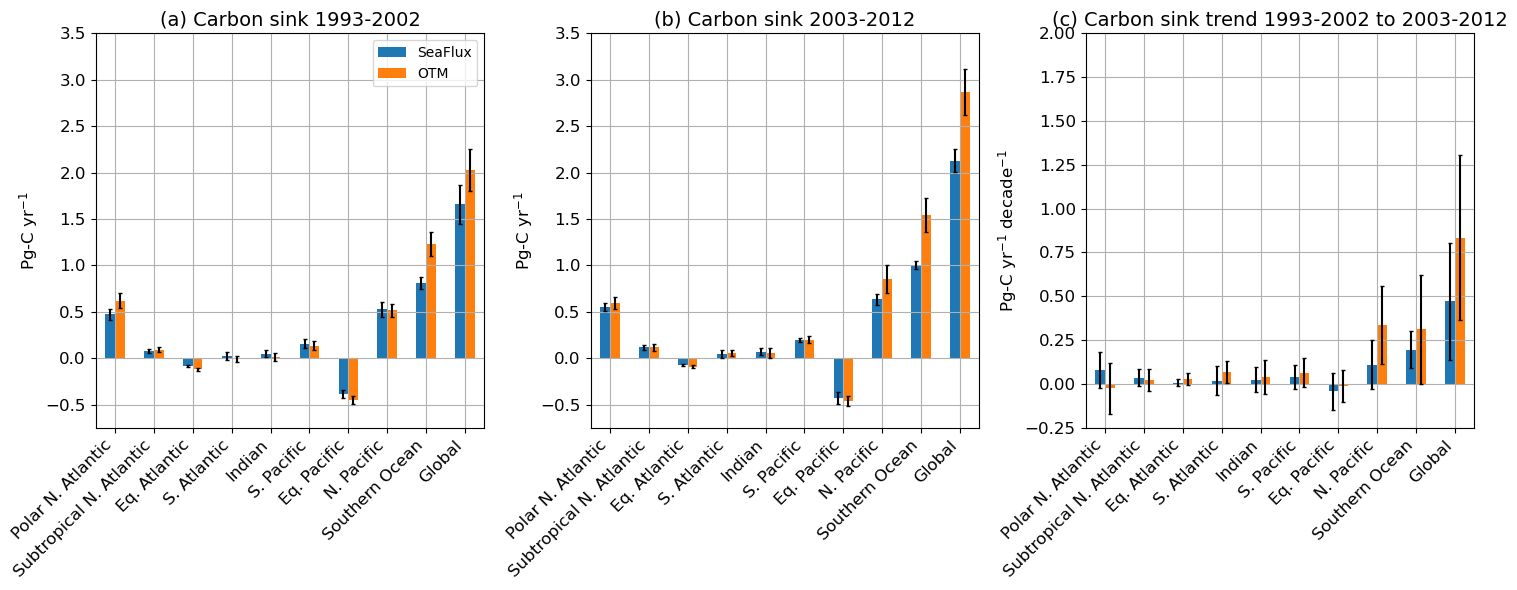

In [16]:
# Plot basin-integrated fluxes and trends

ylim=(-0.75,3.5)
ylim2=(-0.25,2)
fig, axes = plt.subplots(1,3,figsize=(15,6))
fs=12

df_p1 = pd.DataFrame({'SeaFlux': dC_prior_ensmean_p1, 'OTM': dC_OTM_ensmean_p1}, index = np.append(Basins, 'Global'))
df_p2 = pd.DataFrame({'SeaFlux': dC_prior_ensmean_p2,'OTM': dC_OTM_ensmean_p2}, index = np.append(Basins, 'Global'))
df_p1p2 = pd.DataFrame({'SeaFlux': prior_p1p2_trend,'OTM': OTM_p1p2_trend}, index = np.append(Basins, 'Global'))


ax1 = df_p1.plot(kind='bar',ax=axes[0],rot=90,yerr=flux_err_p1,capsize=1.5)
ax1.set_ylabel('Pg-C yr$^{-1}$',fontsize=fs)
ax1.set_title('(a) Carbon sink ' + mid_early_p1 + '-' + mid_late_p1,fontsize=fs+2)
ax1.set_ylim(ylim)
ax1.grid()
ax1.set_xticks(np.arange(len(df_p1.index)))  # Set tick positions
ax1.set_xticklabels(df_p1.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax1.tick_params(axis='y', labelsize=fs)


ax2 = df_p2.plot(kind='bar',ax=axes[1],rot=90,yerr=flux_err_p2,capsize=1.5)
ax2.set_ylabel('Pg-C yr$^{-1}$',fontsize=fs)
ax2.set_title('(b) Carbon sink ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xticks(np.arange(len(df_p2.index)))  # Set tick positions
ax2.set_xticklabels(df_p2.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax2.tick_params(axis='y', labelsize=fs)
ax2.get_legend().remove()

ax3 = df_p1p2.plot(kind='bar',ax=axes[2],rot=90,yerr=flux_trend_p1p2_err,capsize=1.5)
ax3.set_ylabel('Pg-C yr$^{-1}$ decade$^{-1}$',fontsize=fs)
ax3.set_title('(c) Carbon sink trend ' + mid_early_p1 + '-' + mid_late_p1 + ' to ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax3.set_ylim(ylim2)
ax3.grid()
ax3.set_xticks(np.arange(len(df_p1p2.index)))  # Set tick positions
ax3.set_xticklabels(df_p1p2.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax3.tick_params(axis='y', labelsize=fs)
ax3.get_legend().remove()

plt.tight_layout()

plt.savefig('carbon_flux_' + Cdef +'.png', bbox_inches='tight', dpi=300, transparent=True)


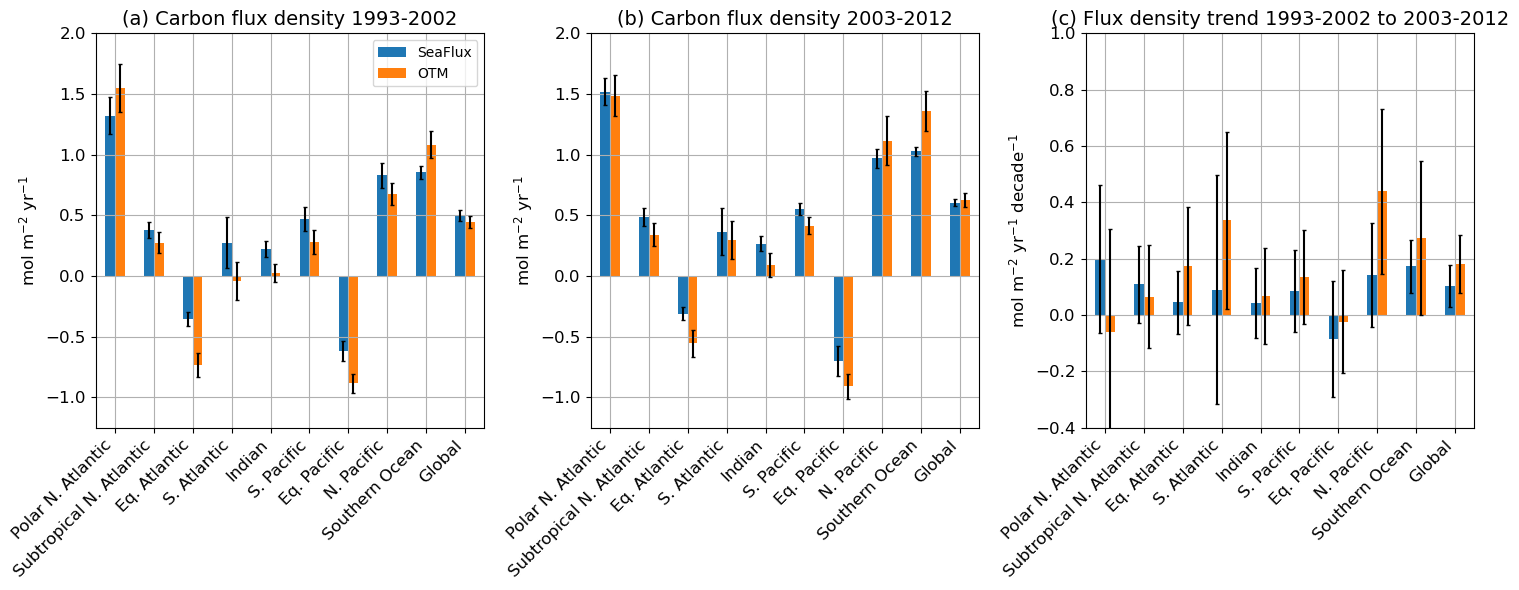

In [17]:
# Plot basin-integrated flux densities and their trends

riverflux = 0.14

ylim=(-1.25,2)
ylim2=(-0.4,1)
fig, axes = plt.subplots(1,3,figsize=(15,6))
fs=12

df_p1 = pd.DataFrame({'SeaFlux': dC_prior_dens_ensmean_p1 + riverflux, 'OTM': dC_OTM_dens_ensmean_p1}, index = np.append(Basins, 'Global'))
df_p2 = pd.DataFrame({'SeaFlux': dC_prior_dens_ensmean_p2 + riverflux,'OTM': dC_OTM_dens_ensmean_p2}, index = np.append(Basins, 'Global'))
df_p1p2 = pd.DataFrame({'SeaFlux': prior_dens_p1p2_trend,'OTM': OTM_dens_p1p2_trend}, index = np.append(Basins, 'Global'))


ax1 = df_p1.plot(kind='bar',ax=axes[0],rot=90,yerr=flux_dens_err_p1,capsize=1.5)
ax1.set_ylabel('mol m$^{-2}$ yr$^{-1}$',fontsize=fs)
ax1.set_title('(a) Carbon flux density ' + mid_early_p1 + '-' + mid_late_p1,fontsize=fs+2)
ax1.set_ylim(ylim)
ax1.grid()
ax1.set_xticks(np.arange(len(df_p1.index)))  # Set tick positions
ax1.set_xticklabels(df_p1.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax1.tick_params(axis='y', labelsize=fs)


ax2 = df_p2.plot(kind='bar',ax=axes[1],rot=90,yerr=flux_dens_err_p2,capsize=1.5)
ax2.set_ylabel('mol m$^{-2}$ yr$^{-1}$',fontsize=fs)
ax2.set_title('(b) Carbon flux density ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xticks(np.arange(len(df_p2.index)))  # Set tick positions
ax2.set_xticklabels(df_p2.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax2.tick_params(axis='y', labelsize=fs)
ax2.get_legend().remove()

ax3 = df_p1p2.plot(kind='bar',ax=axes[2],rot=90,yerr=flux_dens_trend_p1p2_err,capsize=1.5)
ax3.set_ylabel('mol m$^{-2}$ yr$^{-1}$ decade$^{-1}$',fontsize=fs)
ax3.set_title('(c) Flux density trend ' + mid_early_p1 + '-' + mid_late_p1 + ' to ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax3.set_ylim(ylim2)
ax3.grid()
ax3.set_xticks(np.arange(len(df_p1p2.index)))  # Set tick positions
ax3.set_xticklabels(df_p1p2.index, rotation=45, ha="right", fontsize=fs)  # Use 'ha' to align right
ax3.tick_params(axis='y', labelsize=fs)
ax3.get_legend().remove()


plt.tight_layout()
plt.savefig('carbon_flux_density_' + Cdef + '.png', bbox_inches='tight', dpi=300, transparent=True)


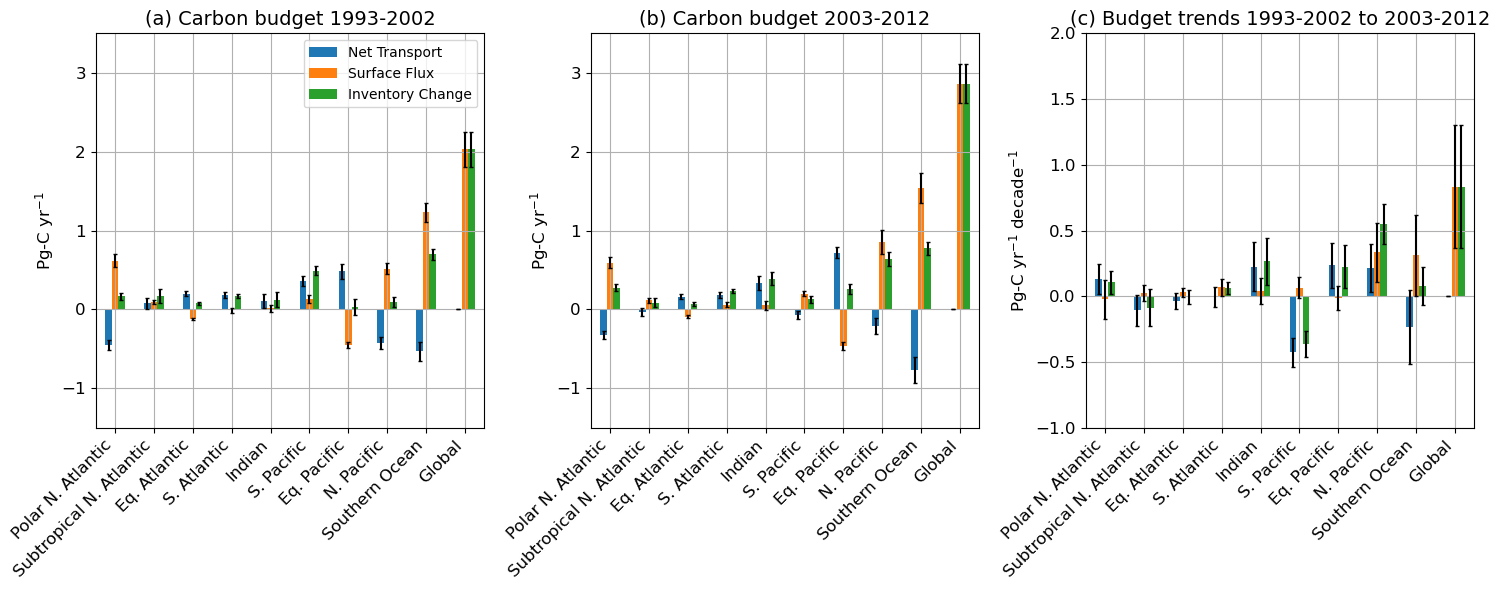

In [18]:
# Plot carbon budget and trends

ylim=(-1.5,3.5)
ylim2=(-1,2)

fig, axes = plt.subplots(1,3,figsize=(15,6))
fs=12

df_p1 = pd.DataFrame({'Net Transport': net_Ctrans_ensmean_p1,\
                   'Surface Flux': dC_OTM_ensmean_p1,\
                  'Inventory Change': dC_inv_ensmean_p1},\
#                     'Residual': dC_inv_ensmean_p1-dC_OTM_ensmean_p1-net_Ctrans_ensmean_p1},\
                  index = np.append(Basins, 'Global'))

df_p2 = pd.DataFrame({'Net Transport': net_Ctrans_ensmean_p2,\
                   'Surface Flux': dC_OTM_ensmean_p2,\
                  'Inventory Change': dC_inv_ensmean_p2},\
#                     'Residual': dC_inv_ensmean_p2-dC_OTM_ensmean_p2-net_Ctrans_ensmean_p2},\
                  index = np.append(Basins, 'Global'))

df_p1p2 = pd.DataFrame({'Net Transport': Ctrans_p1p2_trend,\
                   'Surface Flux': OTM_p1p2_trend,\
                  'Inventory Change': inv_p1p2_trend},\
                  index = np.append(Basins, 'Global'))

ax1 = df_p1.plot(kind='bar',ax=axes[0],rot=90,yerr=budget_err_p1,capsize=1.5)
ax1.set_ylabel('Pg-C yr$^{-1}$',fontsize=fs)
ax1.set_title('(a) Carbon budget ' + mid_early_p1 + '-' + mid_late_p1,fontsize=fs+2)
ax1.set_ylim(ylim)
ax1.grid()
ax1.set_xticks(np.arange(len(df_p1.index)))  # Set tick positions
ax1.set_xticklabels(df_p1.index, rotation=45, ha="right",fontsize=fs)  # Use 'ha' to align right
ax1.tick_params(axis='y', labelsize=fs)

ax2 = df_p2.plot(kind='bar',ax=axes[1],rot=90,yerr=budget_err_p2,capsize=1.5)
ax2.set_ylabel('Pg-C yr$^{-1}$',fontsize=fs)
ax2.set_title('(b) Carbon budget ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax2.set_ylim(ylim)
ax2.grid()
ax2.set_xticks(np.arange(len(df_p2.index)))  # Set tick positions
ax2.set_xticklabels(df_p2.index, rotation=45, ha="right",fontsize=fs)  # Use 'ha' to align right
ax2.tick_params(axis='y', labelsize=fs)
ax2.get_legend().remove()

ax3 = df_p1p2.plot(kind='bar',ax=axes[2],rot=90,yerr=budget_trend_p1p2_err,capsize=1.5)
ax3.set_ylabel('Pg-C yr$^{-1}$ decade$^{-1}$',fontsize=fs)
ax3.set_title('(c) Budget trends ' + mid_early_p1 + '-' + mid_late_p1 + ' to ' + mid_early_p2 + '-' + mid_late_p2,fontsize=fs+2)
ax3.set_ylim(ylim2)
ax3.grid()
ax3.set_xticks(np.arange(len(df_p1p2.index)))  # Set tick positions
ax3.set_xticklabels(df_p1p2.index, rotation=45, ha="right",fontsize=fs)  # Use 'ha' to align right
ax3.tick_params(axis='y', labelsize=fs)
ax3.get_legend().remove()

plt.tight_layout()

plt.savefig('carbon_budget_' + Cdef + '.png', bbox_inches='tight', dpi=300, transparent=True)


#### Summarise fluxes for comparison with products

In [19]:
# Combine OTM and prior fluxes into ocean basins

dC_OTM_all=np.where(dC_OTM_all==0,np.nan,dC_OTM_all)
prior_flux_all=np.where(prior_flux_all==0,np.nan,prior_flux_all)

dC_OTM_sum = np.zeros((5,2))
dC_prior_sum = np.zeros((5,2))
dC_OTM_sum_err = np.zeros((5,2))
dC_prior_sum_err = np.zeros((5,2))

# Atlantic + Arctic

dC_OTM_sum[0,:] = np.nanmean(np.sum(dC_OTM_all[0:4,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_prior_sum[0,:] = np.nanmean(np.sum(prior_flux_all[0:4,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_OTM_sum_err[0,:] = np.nanstd(np.sum(dC_OTM_all[0:4,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_prior_sum_err[0,:] = np.nanstd(np.sum(prior_flux_all[0:4,:,:,:,:,:],axis=0),axis=(1,2,3,4))

# Indian Ocean

dC_OTM_sum[1,:] = np.nanmean(dC_OTM_all[4,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum[1,:] = np.nanmean(prior_flux_all[4,:,:,:,:,:],axis=(1,2,3,4))
dC_OTM_sum_err[1,:] = np.nanstd(dC_OTM_all[4,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum_err[1,:] = np.nanstd(prior_flux_all[4,:,:,:,:,:],axis=(1,2,3,4))

# Pacific Ocean

dC_OTM_sum[2,:] = np.nanmean(np.sum(dC_OTM_all[5:8,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_prior_sum[2,:] = np.nanmean(np.sum(prior_flux_all[5:8,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_OTM_sum_err[2,:] = np.nanstd(np.sum(dC_OTM_all[5:8,:,:,:,:,:],axis=0),axis=(1,2,3,4))
dC_prior_sum_err[2,:] = np.nanstd(np.sum(prior_flux_all[5:8,:,:,:,:,:],axis=0),axis=(1,2,3,4))

# Southern Ocean

dC_OTM_sum[3,:] = np.nanmean(dC_OTM_all[8,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum[3,:] = np.nanmean(prior_flux_all[8,:,:,:,:,:],axis=(1,2,3,4))
dC_OTM_sum_err[3,:] = np.nanstd(dC_OTM_all[8,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum_err[3,:] = np.nanstd(prior_flux_all[8,:,:,:,:,:],axis=(1,2,3,4))

# Global

dC_OTM_sum[4,:] = np.nanmean(dC_OTM_all[9,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum[4,:] = np.nanmean(prior_flux_all[9,:,:,:,:,:],axis=(1,2,3,4))
dC_OTM_sum_err[4,:] = np.nanstd(dC_OTM_all[9,:,:,:,:,:],axis=(1,2,3,4))
dC_prior_sum_err[4,:] = np.nanstd(prior_flux_all[9,:,:,:,:,:],axis=(1,2,3,4))



In [20]:
# Make a table for P1

pd.options.display.float_format = '{:,.2f}'.format
d = {'OTM flux [Pg-C/yr]': dC_OTM_sum[:,0],\
    'OTM flux uncertainty [Pg-C/yr]': dC_OTM_sum_err[:,0],\
    'Prior flux [Pg-C/yr]': dC_prior_sum[:,0],\
        'Prior flux uncertainty [Pg-C/yr]': dC_prior_sum_err[:,0]}    
table = pd.DataFrame(data=d, index=(('Atlantic + Arctic','Indian','Pacific','Southern Ocean','Global')))
table

,OTM flux [Pg-C/yr],OTM flux uncertainty [Pg-C/yr],Prior flux [Pg-C/yr],Prior flux uncertainty [Pg-C/yr]
Atlantic + Arctic,0.58,0.10,0.50,0.09
Indian,0.01,0.04,0.05,0.04
Pacific,0.20,0.08,0.30,0.13
Southern Ocean,1.23,0.12,0.81,0.06
Global,2.03,0.22,1.66,0.21


In [21]:
# Make a table for P2

pd.options.display.float_format = '{:,.2f}'.format
d = {'OTM flux [Pg-C/yr]': dC_OTM_sum[:,1],\
    'OTM flux uncertainty [Pg-C/yr]': dC_OTM_sum_err[:,1],\
    'Prior flux [Pg-C/yr]': dC_prior_sum[:,1],\
        'Prior flux uncertainty [Pg-C/yr]': dC_prior_sum_err[:,1]}    
table = pd.DataFrame(data=d, index=(('Atlantic + Arctic','Indian','Pacific','Southern Ocean','Global')))
table

,OTM flux [Pg-C/yr],OTM flux uncertainty [Pg-C/yr],Prior flux [Pg-C/yr],Prior flux uncertainty [Pg-C/yr]
Atlantic + Arctic,0.68,0.09,0.64,0.04
Indian,0.05,0.06,0.07,0.04
Pacific,0.59,0.20,0.41,0.10
Southern Ocean,1.54,0.19,1.01,0.04
Global,2.86,0.25,2.13,0.13


In [22]:
# Make a table for the trends

pd.options.display.float_format = '{:,.2f}'.format
d = {'OTM flux trend [Pg-C/yr/decade]': dC_OTM_sum[:,1]-dC_OTM_sum[:,0],\
    'OTM flux trend uncertainty [Pg-C/yr/decade]': dC_OTM_sum_err[:,1]+dC_OTM_sum_err[:,0],\
    'Prior flux trend [Pg-C/yr/decade]': dC_prior_sum[:,1]-dC_prior_sum[:,0],\
        'Prior flux trend uncertainty [Pg-C/yr/decade]': dC_prior_sum_err[:,1]+dC_prior_sum_err[:,0]}    
table = pd.DataFrame(data=d, index=(('Atlantic + Arctic','Indian','Pacific','Southern Ocean','Global')))
table

,OTM flux trend [Pg-C/yr/decade],OTM flux trend uncertainty [Pg-C/yr/decade],Prior flux trend [Pg-C/yr/decade],Prior flux trend uncertainty [Pg-C/yr/decade]
Atlantic + Arctic,0.10,0.19,0.14,0.13
Indian,0.04,0.10,0.02,0.07
Pacific,0.39,0.28,0.11,0.23
Southern Ocean,0.31,0.31,0.20,0.11
Global,0.83,0.47,0.47,0.33
